In [1]:
%pip install scikit-surprise recmetrics pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


# Preprocessing and Exploratory Data Analysis

**About Dataset**

---


*Context*:

The dataset contains cleaned and preprocessed 10M+ samples of user recommendations (reviews) from a Steam Store - a leading online platform for purchasing and downloading video games, DLC, and other gaming-related content. Additionally, it contains detailed information about games and add-ons.


---


*Content*:

The dataset consists of three main entities:

*games.csv* - a table of games (or add-ons) information on ratings, pricing in US dollars $, release date, etc. A piece of extra non-tabular details on games, such as descriptions and tags, is in a metadata file;

*users.csv* - a table of user profiles' public information: the number of purchased products and reviews published;

*recommendations.csv* - a table of user reviews: whether the user recommends a product. The table represents a many-many relation between a game entity and a user entity.
The dataset does not contain any personal information about users on a Steam Platform. A preprocessing pipeline anonymized all user IDs. All collected data is accessible to a member of the general public.

In [2]:
import pandas as pd
import json
import numpy as np

In [3]:
recommendations = pd.read_csv('SteamDataset/recommendations.csv')
users = pd.read_csv('SteamDataset/users.csv')
games = pd.read_csv('SteamDataset/games.csv')

The metadata is a nested json, so let's read line-by-line, append to a list then make a dataframe.

In [4]:
d = []
for line in open(('SteamDataset/games_metadata.json'),encoding="utf8"):
  d.append(json.loads(line))
games_metadata = pd.DataFrame(d)

Let's investigate how many samples in each table.

In [5]:
pd.DataFrame([
    ["Recommendations", len(recommendations.index)],
    ["Users", len(users.index)],
    ["Games", len(games.index)],
    ["Games metadata", len(games_metadata.index)]
], columns=["Dataframe", "Records"]).style.hide(axis="index")

Dataframe,Records
Recommendations,11265799
Users,6167727
Games,48318
Games metadata,48318


Let's preview the Games table. It contains the following attributes:

Primary key: native product ID on Steam;

Product title;

Product release date;

OS support (Windows, MacOS, Linux);

Product rating category;

Ratio of positive feedbacks;

Number of reviews left;

Pricing (original and discounted);

Steam Deck compatibility.

In [6]:
games.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,19.99,0.0,True
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
2,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
3,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
4,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True


Users table contains following attributes:

Primary key: user autogenerated ID;

Number of products purchased by the user;

Number of reviews published on Steam;

In [7]:
users.head()

,user_id,products,reviews
0,6043251,156,1
1,3802782,329,3
2,2053748,176,2
3,2214328,98,2
4,2451716,144,3


Recommendations table contains following attributes:

Primary key: review auto-generated ID;

Foreign key on Games table: native product ID on Steam;

Foreign key on Users table: user autogenerated ID;

How many users found a recommendation helpful/funny;

Product recommended (not recommended) by user;

How may hours played by the user.

In [8]:
recommendations.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,21058,0
1,304390,4,0,2017-02-17,False,11.5,1153,1
2,1085660,2,0,2019-11-17,True,336.5,96124,2
3,703080,0,0,2022-09-23,True,27.4,98074,3
4,526870,0,0,2021-01-10,True,7.9,9634,4


Check missing values in tables

What is the percentage of missing values in a dataframe? Currently, there are no missing values in the dataset, so that we can proceed with further investigation.

In [9]:
def perc_na(df: pd.DataFrame) -> float:
    """Calculates a percentage of missing values in the dataframe."""
    return np.count_nonzero(df.isnull().values) / (df.shape[0] * df.shape[1]) * 100.0


pd.DataFrame([
    ["Recommendations", perc_na(recommendations)],
    ["Users", perc_na(users)],
    ["Games", perc_na(games)]
], columns=["Dataframe", "% of missing values"]).style.hide(axis="index")

Dataframe,% of missing values
Recommendations,0.000000
Users,0.000000
Games,0.000000


The date release field is object, so let's convert that to datetime.

In [10]:
games['date_release']=pd.to_datetime(games['date_release'])

Base statistics

Before we proceed with the key investigations, we need to get a descriptive statistics on numerical data.

In [11]:
games[["positive_ratio", "user_reviews", "price_final", "discount"]].describe(percentiles=[.1, .25, .5, .75, .9]).round(2).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
positive_ratio,48318.0,76.92,18.18,0.0,51.0,67.00,81.00,91.00,96.00,100.00
user_reviews,48318.0,1767.66,38168.21,10.0,12.0,20.00,51.00,215.00,1125.00,6941137.00
price_final,48318.0,8.67,11.47,0.0,0.0,0.99,4.99,11.24,19.99,299.99
discount,48318.0,5.08,18.01,0.0,0.0,0.00,0.00,0.00,0.00,90.00


In [12]:
users[["products", "reviews"]].describe(percentiles=[.1, .25, .5, .75, .9]).round(2).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
products,6167727.0,134.99,267.23,0.0,8.0,23.0,64.0,154.0,312.0,29308.0
reviews,6167727.0,1.83,2.33,0.0,1.0,1.0,1.0,2.0,3.0,271.0


In [13]:
recommendations[["helpful", "funny", "hours"]].describe(percentiles=[.1, .25, .5, .75, .9]).round(2).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
helpful,11265799.0,3.48,56.40,0.0,0.0,0.0,0.0,0.0,3.0,36212.0
funny,11265799.0,1.18,40.23,0.0,0.0,0.0,0.0,0.0,0.0,28088.0
hours,11265799.0,147.70,210.06,0.0,5.3,16.2,54.5,181.1,455.5,999.9


Popularity Analysis:

In this analysis we will define "popular" as games having high number number of user reviews. So, games with higher number of reviews means it is much more popular than games with lower number of user reviews.

1. Top 10 popular games of 2022 with positive reviews

First, filttering games which was released in 2022 and has positive_ratio more than 90. Then sorting the data by user_reviews and positive_ratio in descending order to get popular games that people liked the most.

In [14]:
df = games
game_data1=df.loc[(df['date_release'].dt.year==2022) & (df['positive_ratio']>=90)].sort_values(['user_reviews','positive_ratio'],ascending=[False,False]).head(10)
game_data1[['title','user_reviews','positive_ratio']]

,title,user_reviews,positive_ratio
9226,ELDEN RING,481754,91
3591,Raft,218598,93
2668,Vampire Survivors,175903,98
1351,Stray,101109,97
6587,God of War,65968,97
13119,Teardown,60815,96
12167,Marvel’s Spider-Man Remastered,41232,96
7964,Cult of the Lamb,40135,93
8307,PowerWash Simulator,29465,97
10731,LEGO® Star Wars™: The Skywalker Saga,28451,92


2. Top 10 popular games of 2022 with mixed or lower reviews

Filtering data which has positive_ratio less than 70 and sorting by user_reviews and positive_ratio columns.

In [15]:
df = games
game_data2=df.loc[(df['date_release'].dt.year==2022) & (df['positive_ratio']<70)].sort_values(['user_reviews','positive_ratio'],ascending=[False,True]).head(10)
game_data2[['title','user_reviews','positive_ratio']]

,title,user_reviews,positive_ratio
16364,Call of Duty®: Modern Warfare® II,316804,62
38840,Mirror 2: Project X,110981,26
2112,EA SPORTS™ FIFA 23,67263,50
12660,Warhammer 40000: Darktide,54741,54
19737,World War 3,49594,54
20602,The Cycle: Frontier,39025,61
393,Dread Hunger,38500,61
10539,The Callisto Protocol™,21737,62
28674,Call of Duty®: Warzone™ 2.0,19770,34
14964,Victoria 3,19223,67


3. Top 10 popular games of 2022 among mac apple users

Filtering data that released in 2022, has positive_ratio more than 90 and are available for mac users.

In [16]:
df = games
game_data3=df.loc[(df['date_release'].dt.year==2022) & (df['positive_ratio']>=90) & (df['mac']==True)].sort_values(['user_reviews','positive_ratio'],ascending=[False,False]).head(10)
game_data3[['title','user_reviews','positive_ratio']]

,title,user_reviews,positive_ratio
2668,Vampire Survivors,175903,98
7964,Cult of the Lamb,40135,93
2773,NEEDY STREAMER OVERLOAD,19517,95
18158,20 Minutes Till Dawn,18493,92
4267,The Stanley Parable: Ultra Deluxe,18171,94
17732,Stacklands,16917,96
3820,Rogue Legacy 2,11679,90
10504,Quaver,11567,92
28789,The Looker,10889,97
17413,Soulstone Survivors,8873,91


Genre Popularity Analysis:


In [17]:
from matplotlib import pyplot as plt

In [18]:
# Merging the two data frames
gamesdf = games.merge(games_metadata, on='app_id')
# These are the columns that we are interested in
relevant_cols = ['app_id', 'title', 'positive_ratio', 'user_reviews', 'tags']
gamesdf = gamesdf[relevant_cols]
# Sort by user reviews to keep the top 100 reviewed games
gamesdf = gamesdf.sort_values(by = 'user_reviews', ascending = False)
gamesdf = gamesdf.head(100)
review_avg = gamesdf['user_reviews'].mean()

Series Size  246
Average Common Genres  8.130081300813009


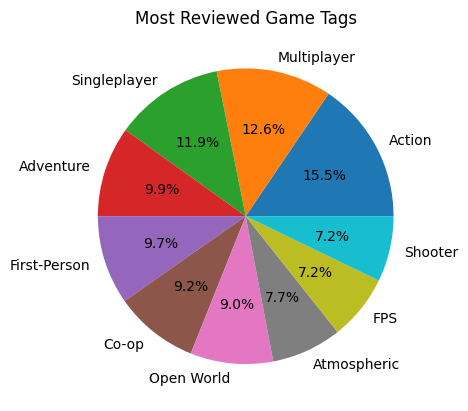

In [19]:
genres = gamesdf['tags']
count_list = []
for i in genres:
    for j in i:
        count_list.append(j)

sorted_genres = pd.value_counts(np.array(count_list))
sorted_genres = sorted_genres.sort_values(ascending=False)
print("Series Size ", sorted_genres.size)
print("Average Common Genres ", sorted_genres.mean())

# Create a chart to help us see our results
genre_slice = sorted_genres.head(10)
labels = genre_slice.keys()

fig, ax = plt.subplots()
plt.title('Most Reviewed Game Tags')
pchart = ax.pie(genre_slice, labels = labels, autopct='%1.1f%%')

Based on this, we can see that some of the most popular games share common tags. However, some of these tags seem like they are very similar, things like Multiplayer, Co-op, and Online Co-op are three tags that one game could have. Some insights that we can find from this list is that Action is the most popular genre, with other notable tags such as Adventure, Simulation, FPS, RPG, and Strategy. Some of these tags describe features in a game rather than a genre, popular features seem to be Multiplayer, Open World, and First Person Shooter (FPS). The amount of multiplayer and singleplayer games are very close to being even, therefore it does not seem like there is a strong preference between one or the other.
This list does have some flaws however. This list of games was gathered based on the amount of reviews a game has, whether the reviews were positive or not had no bearing. Now it could be worthwhile looking at some of the most positively reviewed games and comparing their tags to the most common ones that we have found here.

Series Size  108
Average Common Genres  1.8518518518518519


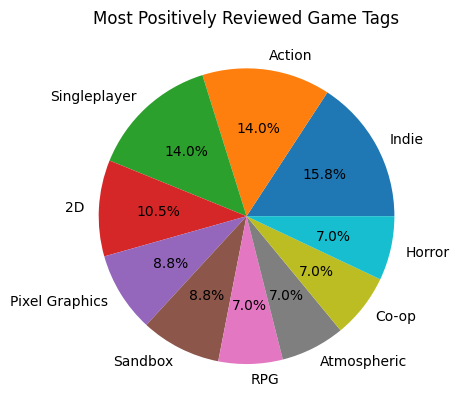

In [20]:
gamesdf = gamesdf.sort_values('positive_ratio', ascending=False)
positivedf = gamesdf.head(10)
tags = positivedf['tags']
count_list = []
for i in tags:
    for j in i:
        count_list.append(j)

sorted_tags = pd.value_counts(np.array(count_list))
sorted_tags = sorted_tags.sort_values(ascending=False)
print("Series Size ", sorted_tags.size)
print("Average Common Genres ", sorted_tags.mean())  

# Create a chart to help us see our results
tag_slice = sorted_tags.head(10)
labels = tag_slice.keys()

fig, ax = plt.subplots()
plt.title('Most Positively Reviewed Game Tags')
pchart = ax.pie(tag_slice, labels = labels, autopct='%1.1f%%')

Now we find a very interesting result. After taking the most positively reviewed games, the common tags look very different from before. We see now that instead of Action, Indie is the most popular tag on this list. Action is still a close second. We also see that singleplayer is more common now than multiplayer. New tags that were previously not as significant in the larger list, such as 2D, Pixel Graphics, Horror, Building, and Roguelike. From this we can see that indie games perform extremely well when they focus on creating a strong singleplayer experience, with some of the other tags mentioned in the graph such as Sandbox and RPG. On the other hand, larger studios will have more success with making a game that is either singleplayer or multiplayer and it has elements which would make it an Adventure, FPS, and Open World.


# Neighbourhood based collaborative filtering

Reducing rows because colab has RAM limit

In [21]:
n = 80000
recommendations = pd.read_csv('SteamDataset/recommendations.csv')

In [22]:
import math
def scal_f(df):
  e = 2.718
  if(df['is_recommended']):
    return df['hours']
  else:
    return math.log2((1+df['hours'])) - 10
recommendations = recommendations[recommendations.groupby('user_id')['user_id'].transform('size') > 15]
recommendations

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
58,602960,0,0,2022-01-05,True,41.9,279151,58
138,570940,348,39,2021-12-11,False,73.3,2199166,138
139,397540,0,0,2020-07-18,True,86.3,2243392,139
141,39210,0,0,2021-04-09,True,123.1,2260360,141
151,1196590,0,0,2022-07-03,True,19.0,2575791,151
...,...,...,...,...,...,...,...,...
11265720,750920,32,0,2021-10-29,True,526.3,5583454,11265720
11265723,666140,7,0,2018-07-31,True,289.4,1153783,11265723
11265756,476600,2788,79,2017-11-03,False,31.9,5110523,11265756
11265770,640820,2,0,2021-12-02,True,69.9,3634187,11265770


In [23]:
recommendations['rating'] = recommendations.apply(scal_f, axis=1)
recommendations['rating'] = recommendations.groupby(['user_id'])['rating'].transform(lambda x: pd.qcut(x.rank(method='first'), 5,labels=range(1,6), duplicates='drop'))
recommendations

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,rating
58,602960,0,0,2022-01-05,True,41.9,279151,58,5
138,570940,348,39,2021-12-11,False,73.3,2199166,138,1
139,397540,0,0,2020-07-18,True,86.3,2243392,139,4
141,39210,0,0,2021-04-09,True,123.1,2260360,141,5
151,1196590,0,0,2022-07-03,True,19.0,2575791,151,4
...,...,...,...,...,...,...,...,...,...
11265720,750920,32,0,2021-10-29,True,526.3,5583454,11265720,5
11265723,666140,7,0,2018-07-31,True,289.4,1153783,11265723,5
11265756,476600,2788,79,2017-11-03,False,31.9,5110523,11265756,1
11265770,640820,2,0,2021-12-02,True,69.9,3634187,11265770,4


In [24]:
first_n_users = recommendations['user_id'].unique()[:n]
recommendations = recommendations[recommendations.user_id.isin(first_n_users)].sample(n=80000,random_state=42)
recommendations

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,rating
10673770,1510460,0,0,2021-04-19,True,3.1,5604637,10673770,2
8167413,433340,2,0,2017-01-31,False,13.8,4798514,8167413,1
8699883,42680,4,2,2021-12-08,True,3.8,730370,8699883,1
9634245,438740,2,0,2017-05-31,True,38.1,5146280,9634245,3
8501878,262060,0,0,2019-11-18,True,60.8,374419,8501878,5
...,...,...,...,...,...,...,...,...,...
6249736,979690,0,0,2022-01-09,True,11.9,3749844,6249736,5
10572801,271260,2,0,2018-10-01,False,29.2,4943037,10572801,2
10914456,342180,0,0,2020-02-22,True,2.8,1823869,10914456,2
6689373,4500,0,0,2022-02-15,True,13.8,3052745,6689373,3


<Axes: >

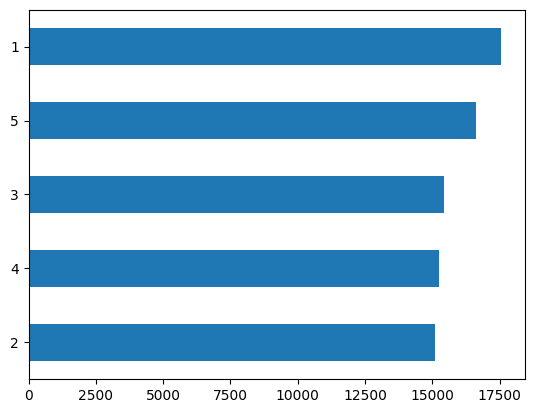

In [25]:
recommendations.rating.value_counts().sort_values().plot(kind = 'barh')

In [26]:
from surprise import SVD, AlgoBase
from surprise import Dataset, Reader, accuracy, get_dataset_dir
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
import heapq
from surprise import PredictionImpossible
class SymmetricAlgo(AlgoBase):
    """This is an abstract class aimed to ease the use of symmetric algorithms.
    A symmetric algorithm is an algorithm that can be based on users or on
    items indifferently, e.g. all the algorithms in this module.
    When the algo is user-based x denotes a user and y an item. Else, it's
    reversed.
    """

    def __init__(self, sim_options={}, verbose=True, **kwargs):

        AlgoBase.__init__(self, sim_options=sim_options, **kwargs)
        self.verbose = verbose

    def fit(self, trainset):

        AlgoBase.fit(self, trainset)

        ub = self.sim_options["user_based"]
        self.n_x = self.trainset.n_users if ub else self.trainset.n_items
        self.n_y = self.trainset.n_items if ub else self.trainset.n_users
        self.xr = self.trainset.ur if ub else self.trainset.ir
        self.yr = self.trainset.ir if ub else self.trainset.ur

        return self

    def switch(self, u_stuff, i_stuff):
        """Return x_stuff and y_stuff depending on the user_based field."""

        if self.sim_options["user_based"]:
            return u_stuff, i_stuff
        else:
            return i_stuff, u_stuff


In [27]:
class KNNWithMeans(SymmetricAlgo):
    """A basic collaborative filtering algorithm, taking into account the mean
    ratings of each user.

    """

    def __init__(self, k=40, min_k=1, sim_options={}, verbose=True, **kwargs):

        SymmetricAlgo.__init__(self, sim_options=sim_options, verbose=verbose, **kwargs)

        self.k = k
        self.min_k = min_k

    def fit(self, trainset):

        SymmetricAlgo.fit(self, trainset)
        self.sim = self.compute_similarities()

        self.means = np.zeros(self.n_x)
        for x, ratings in self.xr.items():
            self.means[x] = np.mean([r for (_, r) in ratings])

        return self

    def estimate(self, u, i):

        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")

        x, y = self.switch(u, i)

        neighbors = [(x2, self.sim[x, x2], r) for (x2, r) in self.yr[y]]
        k_neighbors = heapq.nlargest(self.k, neighbors, key=lambda t: t[1])

        est = self.means[x]

        # compute weighted average
        sum_sim = sum_ratings = actual_k = 0
        for (nb, sim, r) in k_neighbors:
            if sim > 0:
                sum_sim += sim
                sum_ratings += sim * (r - self.means[nb])
                actual_k += 1

        if actual_k < self.min_k:
            sum_ratings = 0

        try:
            est += sum_ratings / sum_sim
        except ZeroDivisionError:
            pass  # return mean

        details = {"actual_k": actual_k}
        return est, details

In [28]:

def read_item_names(app_df):
    """Read the u.item file from dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    """
    app = app_df
    rid_to_name = dict(zip(app['app_id'], app['title']))
    name_to_rid = dict(zip( app['title'],app['app_id']))

    return rid_to_name, name_to_rid

def print_k_nearest_apps(ratings_df, app_df, app_name):
    
  # First, train the algorithm to compute the similarities between items
  reader = Reader(rating_scale=(1, 5))
  # The columns must correspond to user id, item id and ratings (in that order).
  data = Dataset.load_from_df(ratings_df[["user_id", "app_id", "rating"]], reader)
  trainset = data.build_full_trainset()
  sim_options = {"name": "pearson_baseline", "user_based": False}
  algo = KNNWithMeans(sim_options=sim_options)
  algo.fit(trainset)

  # Read the mappings raw id <-> movie name
  rid_to_name, name_to_rid = read_item_names(app_df)

  # Retrieve inner id of the movie Toy Story
  app_raw_id = name_to_rid[app_name]
  app_inner_id = algo.trainset.to_inner_iid(app_raw_id)

  # Retrieve inner ids of the nearest neighbors of Toy Story.
  app_neighbors = algo.get_neighbors(app_inner_id, k=10)

  # Convert inner ids of the neighbors into names.
  app_neighbors = (
      algo.trainset.to_raw_iid(inner_id) for inner_id in app_neighbors
  )
  app_neighbors = (rid_to_name[rid] for rid in app_neighbors)

  print()
  print(f"The 10 nearest neighbors of {app_name} are:")
  for i in app_neighbors:
      print(i)  

In [29]:
print_k_nearest_apps(recommendations, games, 'Rust')

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

The 10 nearest neighbors of Rust are:
Grand Theft Auto V
Space Engineers
VRChat
BeamNG.drive
RimWorld
Metro Exodus
Red Dead Redemption 2
Call of Duty®: Black Ops III
The Witcher® 3: Wild Hunt
Call of Duty®: Modern Warfare® II


In [30]:
print_k_nearest_apps(recommendations, games, 'Team Fortress 2')

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

The 10 nearest neighbors of Team Fortress 2 are:
Borderlands 2
Stellaris
Killing Floor 2
Grand Theft Auto IV: The Complete Edition
Sonic Adventure 2
Shadow of the Tomb Raider: Definitive Edition
Chicken Invaders Universe
Slime Rancher
Call of Duty®: Modern Warfare® 3
Friday the 13th: The Game


In [31]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(recommendations[["user_id", "app_id", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.4)
algo = KNNWithMeans()
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions_ngd = algo.test(testset)
# Then compute RMSE
accuracy.rmse(predictions_ngd)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.7876


1.7876075579153865

In [32]:
uid = int(6645)  # raw user id (as in the ratings file). They are **int**!
iid = int(377160)  # raw item id (as in the ratings file). They are **int**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=1, verbose=True)

user: 6645       item: 377160     r_ui = 1.00   est = 2.97   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [33]:
#cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [34]:
# from collections import defaultdict

# from surprise import Dataset, SVDpp, KNNBaseline
# from surprise.model_selection import KFold


# def precision_recall_at_k(predictions, k=10, threshold=3):
#     """Return precision and recall at k metrics for each user"""

#     # First map the predictions to each user.
#     user_est_true = defaultdict(list)
#     for uid, _, true_r, est, _ in predictions:
#         user_est_true[uid].append((est, true_r))

#     precisions = dict()
#     recalls = dict()
#     for uid, user_ratings in user_est_true.items():

#         # Sort user ratings by estimated value
#         user_ratings.sort(key=lambda x: x[0], reverse=True)

#         # Number of relevant items
#         n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

#         # Number of recommended items in top k
#         n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

#         # Number of relevant and recommended items in top k
#         n_rel_and_rec_k = sum(
#             ((true_r >= threshold) and (est >= threshold))
#             for (est, true_r) in user_ratings[:k]
#         )

#         # Precision@K: Proportion of recommended items that are relevant
#         # When n_rec_k is 0, Precision is undefined. We here set it to 0.

#         precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

#         # Recall@K: Proportion of relevant items that are recommended
#         # When n_rel is 0, Recall is undefined. We here set it to 0.

#         recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

#     return precisions, recalls


# reader = Reader(rating_scale=(1, 5))
#   # The columns must correspond to user id, item id and ratings (in that order).
# data = Dataset.load_from_df(recommendations[["user_id", "app_id", "rating"]], reader)
# kf = KFold(n_splits=5)
# #algo = SVD()

# for trainset, testset in kf.split(data):
#     algo.fit(trainset)
#     predictions = algo.test(testset)
#     precisions, recalls = precision_recall_at_k(predictions, k=5)

#     # Precision and recall can then be averaged over all users
#     print(sum(prec for prec in precisions.values()) / len(precisions))
#     print(sum(rec for rec in recalls.values()) / len(recalls))

# Content based filtering

In [35]:
meta_df = games_metadata.drop(columns = 'description', axis = 1)

In [36]:
meta_df 

,app_id,tags
0,10090,"[Zombies, World War II, FPS, Multiplayer, Acti..."
1,13500,"[Action, Adventure, Parkour, Third Person, Gre..."
2,22364,[Action]
3,113020,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
4,226560,"[Zombies, Adventure, Survival, Action, Third P..."
...,...,...
48313,1803600,"[Stealth, Action, Real Time Tactics, Isometric..."
48314,1811990,"[Card Battler, Difficult, Roguelike Deckbuilde..."
48315,1868120,"[FPS, Third-Person Shooter, Multiplayer, Shoot..."
48316,2206390,"[3D Platformer, Rhythm, Parkour, 3D, Atmospher..."


In [37]:
from collections import Counter
genres_counts = Counter(g for genres in meta_df['tags'] for g in genres)
print(f"There are {len(genres_counts)} genre labels.")
genres_counts

There are 441 genre labels.


Counter({'Zombies': 1374,
         'World War II': 634,
         'FPS': 3046,
         'Multiplayer': 6727,
         'Action': 21373,
         'Shooter': 4318,
         'Co-op': 3353,
         'Singleplayer': 21832,
         'Moddable': 758,
         'First-Person': 5468,
         'War': 1373,
         'Online Co-Op': 1864,
         'Gore': 3171,
         'Historical': 1553,
         'Classic': 1347,
         'Survival': 3243,
         'Great Soundtrack': 4053,
         'Tanks': 281,
         'Horror': 4703,
         'Adventure': 19614,
         'Parkour': 522,
         'Third Person': 3138,
         'Platformer': 3848,
         'Time Travel': 248,
         'Atmospheric': 8525,
         'Hack and Slash': 1412,
         'Time Manipulation': 263,
         'Fantasy': 4971,
         'Story Rich': 6986,
         'Dark': 2449,
         'Open World': 3714,
         'Controller': 2618,
         'Dark Fantasy': 1201,
         'Puzzle': 7302,
         'Stealth': 1162,
         'Indie': 27148,
  

The 5 most common genres: 
 [('Indie', 27148), ('Singleplayer', 21832), ('Action', 21373), ('Adventure', 19614), ('Casual', 17159)]


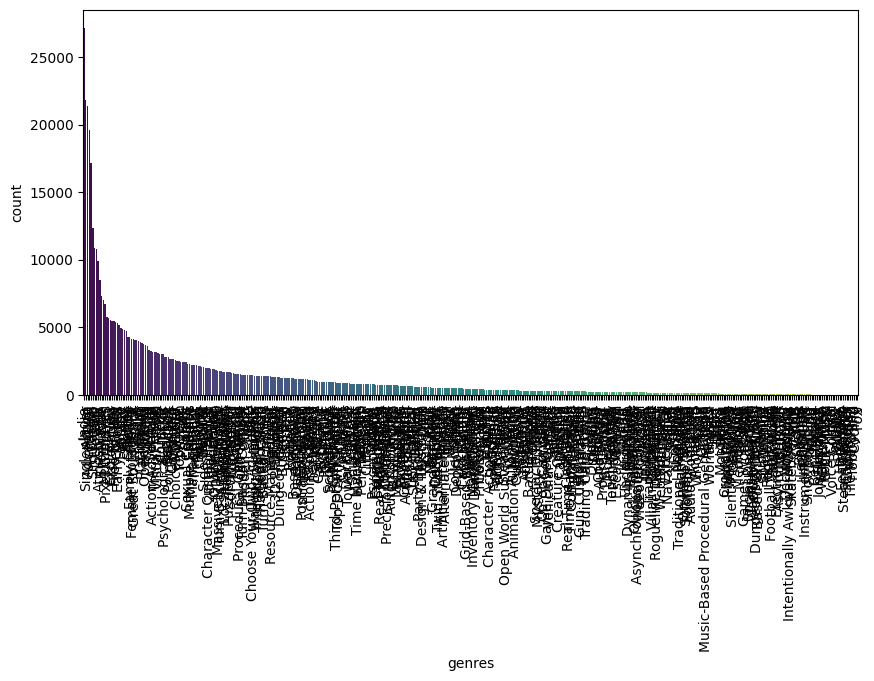

In [38]:
print("The 5 most common genres: \n", genres_counts.most_common(5))
genres_counts_df = pd.DataFrame([genres_counts]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='viridis')
plt.xticks(rotation=90)
plt.show()

In [39]:
games_df = pd.read_csv('SteamDataset/games.csv')
# games_df = pd.concat([games_df.drop(columns=['app_id']), meta_df], axis=1)
games_df = pd.merge(left=games_df, right=meta_df, how="left", on=["app_id", "app_id"])

In [40]:
games_df.drop(columns=['rating', 'date_release', 'discount', 'positive_ratio', 'price_original'], axis=1, inplace=True)
games_df

,app_id,title,win,mac,linux,user_reviews,price_final,steam_deck,tags
0,10090,Call of Duty: World at War,True,False,False,37039,19.99,True,"[Zombies, World War II, FPS, Multiplayer, Acti..."
1,13500,Prince of Persia: Warrior Within™,True,False,False,2199,9.99,True,"[Action, Adventure, Parkour, Third Person, Gre..."
2,22364,BRINK: Agents of Change,True,False,False,21,2.99,True,[Action]
3,113020,Monaco: What's Yours Is Mine,True,True,True,3722,14.99,True,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
4,226560,Escape Dead Island,True,False,False,873,14.99,True,"[Zombies, Adventure, Survival, Action, Third P..."
...,...,...,...,...,...,...,...,...,...
48313,1803600,Gone Rogue,True,False,False,65,12.49,True,"[Stealth, Action, Real Time Tactics, Isometric..."
48314,1811990,Wildfrost,True,False,False,1819,19.99,True,"[Card Battler, Difficult, Roguelike Deckbuilde..."
48315,1868120,BLACK ACE,True,False,False,76,0.00,True,"[FPS, Third-Person Shooter, Multiplayer, Shoot..."
48316,2206390,BandRoll,True,False,False,26,1.59,True,"[3D Platformer, Rhythm, Parkour, 3D, Atmospher..."


In [41]:
games_df['win'] = games_df['win'].transform(lambda x: 1 if bool(x) else 0)
games_df['linux'] = games_df['linux'].transform(lambda x: 1 if bool(x) else 0)
games_df['mac'] = games_df['mac'].transform(lambda x: 1 if bool(x) else 0)
games_df['steam_deck'] = games_df['steam_deck'].transform(lambda x: 1 if bool(x) else 0)
games_df

,app_id,title,win,mac,linux,user_reviews,price_final,steam_deck,tags
0,10090,Call of Duty: World at War,1,0,0,37039,19.99,1,"[Zombies, World War II, FPS, Multiplayer, Acti..."
1,13500,Prince of Persia: Warrior Within™,1,0,0,2199,9.99,1,"[Action, Adventure, Parkour, Third Person, Gre..."
2,22364,BRINK: Agents of Change,1,0,0,21,2.99,1,[Action]
3,113020,Monaco: What's Yours Is Mine,1,1,1,3722,14.99,1,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
4,226560,Escape Dead Island,1,0,0,873,14.99,1,"[Zombies, Adventure, Survival, Action, Third P..."
...,...,...,...,...,...,...,...,...,...
48313,1803600,Gone Rogue,1,0,0,65,12.49,1,"[Stealth, Action, Real Time Tactics, Isometric..."
48314,1811990,Wildfrost,1,0,0,1819,19.99,1,"[Card Battler, Difficult, Roguelike Deckbuilde..."
48315,1868120,BLACK ACE,1,0,0,76,0.00,1,"[FPS, Third-Person Shooter, Multiplayer, Shoot..."
48316,2206390,BandRoll,1,0,0,26,1.59,1,"[3D Platformer, Rhythm, Parkour, 3D, Atmospher..."


In [42]:
games_df

,app_id,title,win,mac,linux,user_reviews,price_final,steam_deck,tags
0,10090,Call of Duty: World at War,1,0,0,37039,19.99,1,"[Zombies, World War II, FPS, Multiplayer, Acti..."
1,13500,Prince of Persia: Warrior Within™,1,0,0,2199,9.99,1,"[Action, Adventure, Parkour, Third Person, Gre..."
2,22364,BRINK: Agents of Change,1,0,0,21,2.99,1,[Action]
3,113020,Monaco: What's Yours Is Mine,1,1,1,3722,14.99,1,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
4,226560,Escape Dead Island,1,0,0,873,14.99,1,"[Zombies, Adventure, Survival, Action, Third P..."
...,...,...,...,...,...,...,...,...,...
48313,1803600,Gone Rogue,1,0,0,65,12.49,1,"[Stealth, Action, Real Time Tactics, Isometric..."
48314,1811990,Wildfrost,1,0,0,1819,19.99,1,"[Card Battler, Difficult, Roguelike Deckbuilde..."
48315,1868120,BLACK ACE,1,0,0,76,0.00,1,"[FPS, Third-Person Shooter, Multiplayer, Shoot..."
48316,2206390,BandRoll,1,0,0,26,1.59,1,"[3D Platformer, Rhythm, Parkour, 3D, Atmospher..."


In [44]:
# games_df = games_df.loc[games_df['user_reviews']>500]
del games_df['tags']
del games_df['user_reviews']
del games_df['price_final']
games_df

,app_id,title,win,mac,linux,steam_deck
0,10090,Call of Duty: World at War,1,0,0,1
1,13500,Prince of Persia: Warrior Within™,1,0,0,1
2,22364,BRINK: Agents of Change,1,0,0,1
3,113020,Monaco: What's Yours Is Mine,1,1,1,1
4,226560,Escape Dead Island,1,0,0,1
...,...,...,...,...,...,...
48313,1803600,Gone Rogue,1,0,0,1
48314,1811990,Wildfrost,1,0,0,1
48315,1868120,BLACK ACE,1,0,0,1
48316,2206390,BandRoll,1,0,0,1


In [45]:
from sklearn.metrics.pairwise import cosine_similarity
tmp = games_df.drop(columns=['app_id', 'title'], axis=1)
cosine_sim = cosine_similarity(tmp, tmp)
print(f"Dimensions of our game features cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our game features cosine similarity matrix: (48318, 48318)


In [46]:
def get_recs(n_recommendations, idx):
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:(n_recommendations+1)]
  similar_movies = [i[0] for i in sim_scores]
  a = pd.read_csv('SteamDataset/games.csv')
  a_id = games_df['app_id'].iloc[idx]
  print(f"Because you liked {a['title'].loc[a['app_id']==a_id]}:")
  print(games_df['title'].iloc[(similar_movies)])


In [47]:
get_recs(10, 1)
get_recs(4, 300)

Because you liked 1    Prince of Persia: Warrior Within™
Name: title, dtype: object:
1                     Prince of Persia: Warrior Within™
2                               BRINK: Agents of Change
4                                    Escape Dead Island
6                                          METAL SLUG 3
8                          Mount & Blade II: Bannerlord
9     Men of War: Assault Squad 2 - Deluxe Edition u...
10                    Hyperdimension Neptunia Re;Birth1
11                                 The Sum of All Fears
12                                           Cold Fear™
13                        LEGO® Harry Potter: Years 1-4
Name: title, dtype: object
Because you liked 300    The Witch & The 66 Mushrooms
Name: title, dtype: object:
1    Prince of Persia: Warrior Within™
2              BRINK: Agents of Change
4                   Escape Dead Island
6                         METAL SLUG 3
Name: title, dtype: object


# Evaluation metrics

In [48]:
#predictions_model = pd.DataFrame(algo.test(testset))
predictions_ngd = pd.DataFrame(algo.test(testset))

In [49]:
test = pd.DataFrame(predictions_ngd)
test.drop("details", inplace=True, axis=1)
test.columns = ['user_id', 'app_id', 'actual', 'cf_ngd_predictions']
test.head()

,user_id,app_id,actual,cf_ngd_predictions
0,1745205,377160,4.0,3.218170
1,299416,250900,4.0,3.833812
2,5373134,1222670,4.0,2.000000
3,215162,666140,4.0,2.750000
4,2353566,221910,5.0,1.666667


In [50]:
cf_model_n = test.pivot_table(index='user_id', columns='app_id', values='cf_ngd_predictions').fillna(0)

In [51]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [52]:
test = test.copy().groupby('user_id', as_index=False)['app_id'].agg({'actual': (lambda x: list(set(x)))})

In [53]:
test = test.set_index("user_id")

In [54]:
# make recommendations for all members in the test data
cf_recs_n = [] = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model_n)
    cf_recs_n.append(cf_predictions)
        
test['cf_ngd_predictions'] = cf_recs_n
test.head()

,actual,cf_ngd_predictions
user_id,,
464,"[323320, 200510]","[200510, 323320, 1084520, 1080750, 1079620, 10..."
569,"[732690, 42700, 335300]","[732690, 42700, 335300, 1066890, 1080750, 1079..."
1040,[70],"[70, 30, 1066780, 1080750, 1079620, 1079210, 1..."
1161,"[431240, 338170, 632360, 17390]","[632360, 17390, 338170, 431240, 30, 1066890, 1..."
1366,[632360],"[632360, 30, 1066780, 1080750, 1079620, 107921..."


In [55]:
popularity_recs = recommendations.app_id.value_counts().head(10).index.tolist()
pop_recs = []
for user in test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

,actual,cf_ngd_predictions,pop_predictions
user_id,,,
464,"[323320, 200510]","[200510, 323320, 1084520, 1080750, 1079620, 10...","[377160, 275850, 1091500, 271590, 1174180, 431..."
569,"[732690, 42700, 335300]","[732690, 42700, 335300, 1066890, 1080750, 1079...","[377160, 275850, 1091500, 271590, 1174180, 431..."
1040,[70],"[70, 30, 1066780, 1080750, 1079620, 1079210, 1...","[377160, 275850, 1091500, 271590, 1174180, 431..."
1161,"[431240, 338170, 632360, 17390]","[632360, 17390, 338170, 431240, 30, 1066890, 1...","[377160, 275850, 1091500, 271590, 1174180, 431..."
1366,[632360],"[632360, 30, 1066780, 1080750, 1079620, 107921...","[377160, 275850, 1091500, 271590, 1174180, 431..."


In [56]:
#make recommendations for all members in the test data

ran_recs = []
for user in test.index:
    random_predictions = recommendations.app_id.sample(5).values.tolist()
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()


,actual,cf_ngd_predictions,pop_predictions,random_predictions
user_id,,,,
464,"[323320, 200510]","[200510, 323320, 1084520, 1080750, 1079620, 10...","[377160, 275850, 1091500, 271590, 1174180, 431...","[588430, 105600, 383120, 829590, 1824220]"
569,"[732690, 42700, 335300]","[732690, 42700, 335300, 1066890, 1080750, 1079...","[377160, 275850, 1091500, 271590, 1174180, 431...","[1039880, 4000, 1325200, 641320, 238960]"
1040,[70],"[70, 30, 1066780, 1080750, 1079620, 1079210, 1...","[377160, 275850, 1091500, 271590, 1174180, 431...","[1235140, 250900, 975370, 599140, 582010]"
1161,"[431240, 338170, 632360, 17390]","[632360, 17390, 338170, 431240, 30, 1066890, 1...","[377160, 275850, 1091500, 271590, 1174180, 431...","[629760, 12210, 548430, 1816670, 227300]"
1366,[632360],"[632360, 30, 1066780, 1080750, 1079620, 107921...","[377160, 275850, 1091500, 271590, 1174180, 431...","[715400, 313120, 436150, 22380, 1172470]"


Recall


In [57]:
actual = test.actual.values.tolist()
cf_ngd_predictions = test.cf_ngd_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()


In [58]:
import recmetrics
import numpy as np

In [59]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.01229008667388949,
 0.017364862250425633,
 0.020578116132693596,
 0.022883341716968472,
 0.02459215012295998,
 0.025764289798620783,
 0.026738606394164744,
 0.02755512409008385,
 0.028328395833922583,
 0.028960173680489164]

In [60]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.0027302275189599132,
 0.0038822679667750086,
 0.004673468159383653,
 0.005255394546767787,
 0.005763520223907547,
 0.005763520223907547,
 0.005763520223907547,
 0.005763520223907547,
 0.005763520223907547,
 0.005763520223907547]

In [61]:
cf_mark_n = []
for K in np.arange(1, 11):
    cf_mark_n.extend([recmetrics.mark(actual, cf_ngd_predictions, k=K)])
cf_mark_n

[0.7322422777054413,
 0.9293816301671123,
 0.9811526185984475,
 0.994462068568244,
 0.9978581924275315,
 0.999109137521922,
 0.9995655719626467,
 0.9997743667191121,
 0.9998883619089469,
 0.9999361478776428]

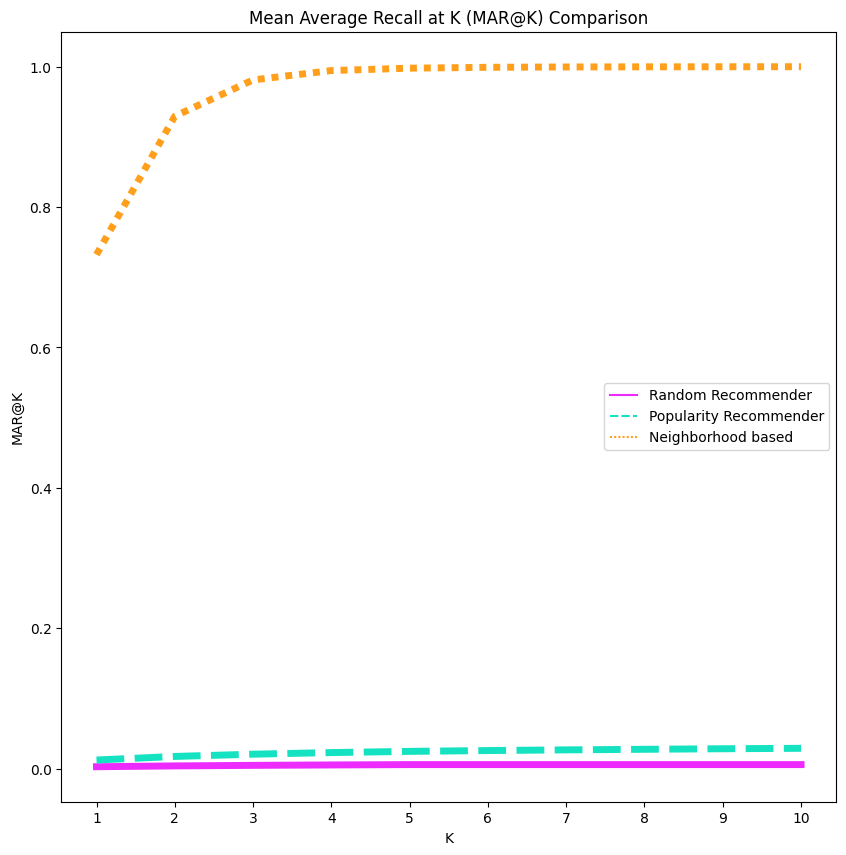

In [62]:
mark_scores = [random_mark, pop_mark, cf_mark_n]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Neighborhood based']

fig = plt.figure(figsize=(10, 10))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [63]:

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [64]:
pop_mapk = []
for K in np.arange(1, 11):
    pop_mapk.extend([mapk(actual, pop_predictions,k= K)])
pop_mapk

[0.020260021668472374,
 0.019298483206933913,
 0.021045503791982664,
 0.02298550920910076,
 0.024625631997110868,
 0.025773248465149872,
 0.026741942190382832,
 0.02755595170534808,
 0.028328902563392842,
 0.02896031258095309]

In [65]:
random_mapk = []
for K in np.arange(1, 11):
    random_mapk.extend([mapk(actual, random_predictions, k=K)])
random_mapk

[0.004279523293607801,
 0.004265980498374865,
 0.004764054411941736,
 0.005271156855663898,
 0.005766642590586252,
 0.0057648368845551945,
 0.005764191989544102,
 0.005763708318285783,
 0.005763520223907547,
 0.005763520223907547]

In [66]:
cf_mapk_n = []
for K in np.arange(1, 11):
    cf_mapk_n.extend([mapk(actual, cf_ngd_predictions, k=K)])
cf_mapk_n

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

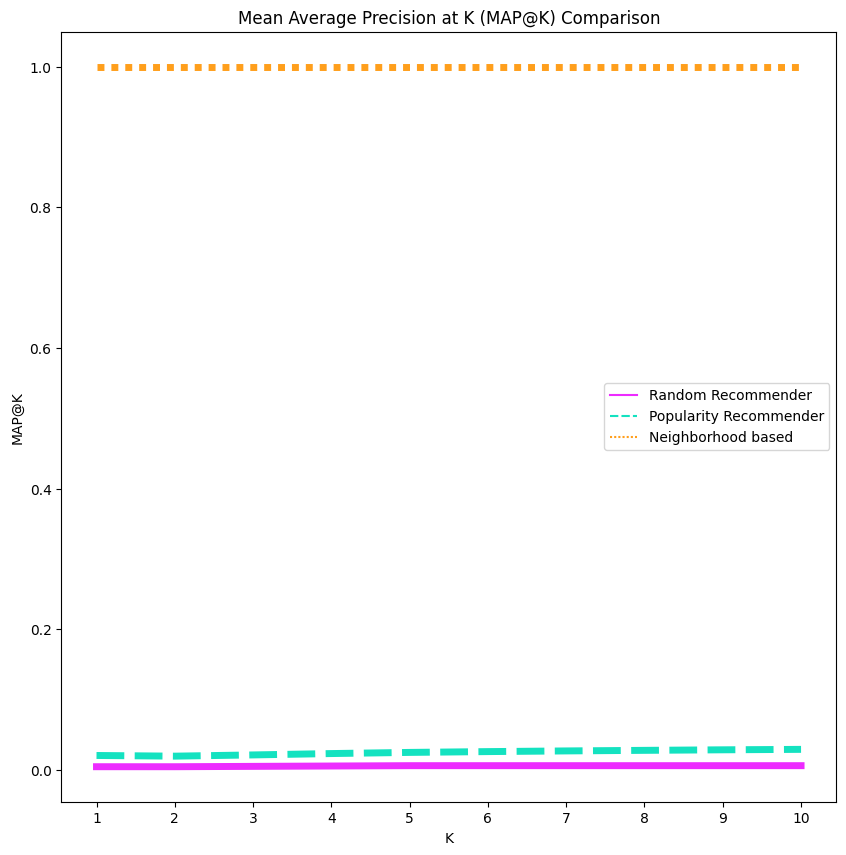

In [67]:
mark_scores = [random_mapk, pop_mapk, cf_mapk_n]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender','Neighborhood based']

fig = plt.figure(figsize=(10, 10))
recmetrics.mapk_plot(mark_scores, model_names=names, k_range=index)

In [68]:
catalog = recommendations.app_id.unique().tolist()
random_coverage = recmetrics.prediction_coverage(ran_recs, catalog)
pop_coverage = recmetrics.prediction_coverage(pop_recs, catalog)
cf_coverage_n = recmetrics.prediction_coverage(cf_recs_n, catalog)

In [69]:
# N=100 observed recommendation lists
random_cat_coverage = recmetrics.catalog_coverage(ran_recs, catalog, 100)
pop_cat_coverage = recmetrics.catalog_coverage(pop_recs, catalog, 100)
cf_cat_coverage_n = recmetrics.catalog_coverage(cf_recs_n, catalog, 100)

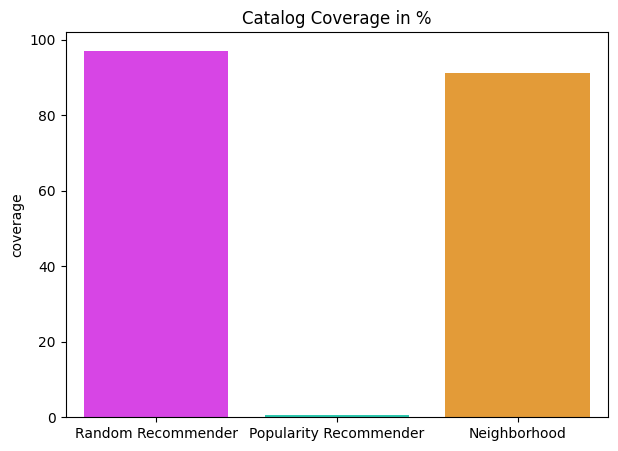

In [70]:
# plot of prediction coverage
coverage_scores = [random_coverage, pop_coverage, cf_coverage_n]
model_names = ['Random Recommender', 'Popularity Recommender', 'Neighborhood']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

In [71]:
nov = recommendations.app_id.value_counts()
pop = dict(nov)

In [72]:
random_novelty,random_mselfinfo_list = recmetrics.novelty(ran_recs, pop, len(users), 10)
pop_novelty,pop_mselfinfo_list = recmetrics.novelty(pop_recs, pop, len(users), 10)
cf_novelty_n,cf_mselfinfo_list = recmetrics.novelty(cf_recs_n, pop, len(users), 10)

In [73]:
print(random_novelty, pop_novelty, cf_novelty_n)

7.807899792586648 13.27177957652021 18.940192493145776


# Hybrid model

In [102]:
def read_item_names(app_df):
    """Read the u.item file from dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    """
    app = app_df
    rid_to_name = dict(zip(app['app_id'], app['title']))
    name_to_rid = dict(zip( app['title'],app['app_id']))

    return rid_to_name, name_to_rid

def get_k_nearest_apps(algo, app_df, app_name):

  # Read the mappings raw id <-> movie name
  rid_to_name, name_to_rid = read_item_names(app_df)

  app_raw_id = name_to_rid[app_name]
  app_inner_id = algo.trainset.to_inner_iid(app_raw_id)

  app_neighbors = algo.get_neighbors(app_inner_id, k=3)

  # Convert inner ids of the neighbors into names.
  app_neighbors = (
      algo.trainset.to_raw_iid(inner_id) for inner_id in app_neighbors
  )
  app_neighbors_names = (rid_to_name[rid] for rid in app_neighbors)

  return app_neighbors, app_neighbors_names

In [75]:
import math
def sim_p(n_x, yr, min_support):

    prods = np.zeros((n_x, n_x), np.double)
    # number of common ys
    freq = np.zeros((n_x, n_x), np.int_)
    # sum (r_xy ^ 2) for common ys
    sqi = np.zeros((n_x, n_x), np.double)
    # sum (r_x'y ^ 2) for common ys
    sqj = np.zeros((n_x, n_x), np.double)
    # the similarity matrix
    sim = np.zeros((n_x, n_x), np.double)

    min_sprt = min_support

    for y, y_ratings in yr.items():
        for xi, ri in y_ratings:
            for xj, rj in y_ratings:
                freq[xi, xj] += 1
                prods[xi, xj] += ri * rj
                sqi[xi, xj] += ri**2
                sqj[xi, xj] += rj**2

    for xi in range(n_x):
        sim[xi, xi] = 1
        for xj in range(xi + 1, n_x):
            if freq[xi, xj] < min_sprt:
                sim[xi, xj] = 0
            else:
                denum = math.sqrt(sqi[xi, xj] * sqj[xi, xj])
                sim[xi, xj] = prods[xi, xj] / denum

            sim[xj, xi] = sim[xi, xj]

    return np.asarray(sim)

In [76]:
class HybridModel(SymmetricAlgo):

    def __init__(self, k=40, min_k=1, sim_options={}, verbose=True, **kwargs):

        SymmetricAlgo.__init__(self, sim_options=sim_options, verbose=verbose, **kwargs)
        self.k = k
        self.min_k = min_k
        self.liked = []
    def fit(self, trainset):

        SymmetricAlgo.fit(self, trainset)
        self.sim = self.compute_similarities()

        return self
    def compute_similarities(self):
        """Build the similarity matrix.

        Returns:
            The similarity matrix."""

        construction_func = {
            "msd": sim_p,
        }

        if self.sim_options["user_based"]:
            n_x, yr = self.trainset.n_users, self.trainset.ir
        else:
            n_x, yr = self.trainset.n_items, self.trainset.ur

        min_support = self.sim_options.get("min_support", 1)

        args = [n_x, yr, min_support]

        name = self.sim_options.get("name", "msd").lower()
        if name == "pearson_baseline":
            shrinkage = self.sim_options.get("shrinkage", 100)
            bu, bi = self.compute_baselines()
            if self.sim_options["user_based"]:
                bx, by = bu, bi
            else:
                bx, by = bi, bu

            args += [self.trainset.global_mean, bx, by, shrinkage]

        try:
            if getattr(self, "verbose", False):
                print(f"Computing the {name} similarity matrix...")
            sim = construction_func[name](*args)
            if getattr(self, "verbose", False):
                print("Done computing similarity matrix.")
            return sim
        except KeyError:
            raise NameError(
                "Wrong sim name "
                + name
                + ". Allowed values "
                + "are "
                + ", ".join(construction_func.keys())
                + "."
            )
    def estimate(self, u, i):

        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")

        x, y = self.switch(u, i)

        neighbors = [(self.sim[x, x2], r) for (x2, r) in self.yr[y]]
        k_neighbors = heapq.nlargest(self.k, neighbors, key=lambda t: t[0])

        # compute weighted average
        sum_sim = sum_ratings = actual_k = 0
        for (sim, r) in k_neighbors:
            if sim > 0:
                sum_sim += sim
                sum_ratings += sim * r
                actual_k += 1

        if actual_k < self.min_k:
            raise PredictionImpossible("Not enough neighbors.")

        est = sum_ratings / sum_sim

        details = {"actual_k": actual_k}
        return est, details
    def get_df_cond():
        print("Enter your maximum price in dollars.")
        max_p = float(input())
        print("Enter some tags you like. Seperate tags by commas.")
        tags = input().split(',')
        print("Do you want to be able to play it on Windows? Enter 1 for yes and 0 for doesn't matter")
        w = int(input())
        print("Do you want to be able to play it on Linux? Enter 1 for yes and 0 for doesn't matter")
        l = int(input())
        print("Do you want to be able to play it on MacOS? Enter 1 for yes and 0 for doesn't matter")
        m = int(input())
        print("Do you want to be able to play it on SteamDeck? Enter 1 for yes and 0 for doesn't matter")
        sd = int(input())
        return [max_p, tags, w, l, m, sd]
    def add_liked(self, item):
        self.liked.append(item)

In [77]:
def narrow():
    meta_df = games_metadata.drop(columns = 'description', axis = 1)
    games = pd.read_csv('SteamDataset/games.csv')
    l = HybridModel.get_df_cond()
    cond = (games['price_final'] <= l[0])
    result = games[cond].app_id
    games = games_df
    cond = (games.app_id.isin(result)) & (games['win']==l[2] if l[3]==1 else True) & (games['linux']==l[3] if l[3]==1 else True) & (games['mac']==l[4] if l[4]==1 else True) & (games['steam_deck']==l[5] if l[5]==1 else True)
    result = games[cond].app_id
    cond = (meta_df.app_id.isin(result)) & (meta_df.tags.map(set(l[1]).issubset)) & (meta_df.app_id.isin(recommendations.app_id))
    result = meta_df[cond].app_id
    return result

In [78]:
def train_hybrid(algo, q):    
    reader = Reader(rating_scale=(1, 5))
    df = recommendations.loc[recommendations.app_id.isin(q)]
    print(df)
    data = Dataset.load_from_df(df[["user_id", "app_id", "rating"]], reader)
    trainset = data.build_full_trainset()
    algo.fit(trainset)

In [79]:
algo = HybridModel(sim_options = {
    "name": "msd"
})
n_id = narrow()
train_hybrid(algo, n_id)

Enter your maximum price in dollars.


 25


Enter some tags you like. Seperate tags by commas.


 Action,Zombies


Do you want to be able to play it on Windows? Enter 1 for yes and 0 for doesn't matter


 1


Do you want to be able to play it on Linux? Enter 1 for yes and 0 for doesn't matter


 0


Do you want to be able to play it on MacOS? Enter 1 for yes and 0 for doesn't matter


 0


Do you want to be able to play it on SteamDeck? Enter 1 for yes and 0 for doesn't matter


 0


           app_id  helpful  funny        date  is_recommended  hours  user_id  \
8891663     21690        0      0  2016-01-19            True   72.4  1866494   
9916394    254700        0      0  2017-10-18           False    1.1   113880   
11210190   418370       61     28  2017-07-29            True   41.8  4867281   
11147316      500        0      0  2021-04-19            True    0.4   131015   
8805000   1180380        0      0  2021-12-20            True    9.3  2776701   
...           ...      ...    ...         ...             ...    ...      ...   
9992490     17470        0      0  2022-08-16            True   10.0  4580536   
11220641   418370       32      3  2018-02-05            True   35.4  6153452   
5639684    242760        0      3  2020-04-25            True   27.4  3199846   
9415306   1621070        0      0  2022-08-07            True    7.6    21903   
11197407   555160       35     19  2018-12-11            True   19.7  6102118   

          review_id rating 

In [80]:
n_id

0          10090
99        362890
1825        7800
1869      921060
2348      379720
2650     1473480
3002      254700
3886      513710
3900      691320
3964      304930
4672     1180380
5853     1552620
6120      360170
6224      266310
6822      219990
6956      363930
7280      965200
7764     1264920
7880     1627850
9525      789760
9693         500
9712      383150
9749      924970
10367     525510
10653    1524630
10688     418370
11223     239140
11870     233740
12312     500260
12417     250400
12961     395200
13042    1969870
13070     366090
13688        220
13800     242760
13918     555160
14196     251570
14536     322210
15194    1137970
15483    1369630
15637      21690
15907    1621070
16184     339230
16246    1621760
16413     671510
17797    1262460
18280        550
18599     224580
18733     666570
19541    1243200
21242      17470
Name: app_id, dtype: int64

In [86]:
con1, con2 = read_item_names(games.loc[games.app_id.isin(n_id)])
import random
seed = random.choice(list(n_id))
y = get_k_nearest_apps(algo, games.loc[games.app_id.isin(n_id)], con1[seed])
for i in y[0]:
    print(con1[i])
print("Enter a list of numbers which you liked!")
z = list(map(int, input().split(',')))
o = []
c = 0
y = get_k_nearest_apps(algo, games.loc[games.app_id.isin(n_id)], con1[seed])
for i in y[0]:
    #print(c, i)
    if c in z:
        o.append(i)
    c += 1
o

Left 4 Dead 2
Dead Island Definitive Edition
Dead Space (2008)
DESOLATE
Guns Gore and Cannoli 2
Enter a list of numbers which you liked!


 1,2


[383150, 17470]

In [87]:
for i in o:
    algo.add_liked(i)
algo.liked

[383150, 17470]

In [90]:
def get_final_rec(algo, n_id):
    liked = algo.liked
    d = {}
    for i in liked:
        for j in get_k_nearest_apps(algo, games.loc[games.app_id.isin(n_id)], con1[i]):
            if(j not in d.keys()):
                d[j] = 1
            else:
                d[j] += 1
    return (max(d, key = d.get))
con1, con2 = read_item_names(games.loc[games.app_id.isin(n_id)])
print("You final recommendations are: ")
for i in get_final_rec(algo, n_id):
    if i not in o:
        print(con1[i])

You final recommendations are: 
resident evil 4 (2005)
Left 4 Dead 2
DESOLATE
Guns Gore and Cannoli 2


In [113]:
#Second example
algo = HybridModel(sim_options = {
    "name": "msd"
})
n_id = narrow()
train_hybrid(algo, n_id)

Enter your maximum price in dollars.


 100


Enter some tags you like. Seperate tags by commas.


 Stealth


Do you want to be able to play it on Windows? Enter 1 for yes and 0 for doesn't matter


 1


Do you want to be able to play it on Linux? Enter 1 for yes and 0 for doesn't matter


 1


Do you want to be able to play it on MacOS? Enter 1 for yes and 0 for doesn't matter


 0


Do you want to be able to play it on SteamDeck? Enter 1 for yes and 0 for doesn't matter


 0


           app_id  helpful  funny        date  is_recommended  hours  user_id  \
11257581   512900       30      0  2022-06-11            True  117.0  4045888   
1095926    218620        0      0  2016-04-14            True  220.1  1913978   
10708984  1545990        0      0  2022-11-14            True    7.3   461206   
4750630    218620       13      0  2016-11-24            True  764.7  6098857   
3987452    218620        2      0  2019-09-06            True   48.4  3725012   
...           ...      ...    ...         ...             ...    ...      ...   
2025139    218620        0      0  2015-08-11            True  252.9  4915124   
7393959    412020        2      0  2020-07-27            True    3.1  3725434   
8929572    238320        0      0  2020-11-14            True    1.5  3840238   
2812591    218620       76      0  2015-10-15           False  250.7  4017204   
3744710    218620        3      0  2014-02-27            True  385.2   566826   

          review_id rating 

In [116]:
con1, con2 = read_item_names(games.loc[games.app_id.isin(n_id)])
seed = random.choice(list(n_id))
y = get_k_nearest_apps(algo, games.loc[games.app_id.isin(n_id)], con1[seed])
for i in y[0]:
    print(con1[i])
print("Enter a list of numbers which you liked!")
z = list(map(int, input().split(',')))
o = []
c = 0
y = get_k_nearest_apps(algo, games.loc[games.app_id.isin(n_id)], con1[seed])
for i in y[0]:
    #print(c, i)
    if c in z:
        o.append(i)
    c += 1
for i in o:
    algo.add_liked(i)
con1, con2 = read_item_names(games.loc[games.app_id.isin(n_id)])
print("You final recommendations are: ")
for i in get_final_rec(algo, n_id):
    if i not in o:
        print(con1[i])

PAYDAY 2
Alien: Isolation
Outlast
Enter a list of numbers which you liked!


 1


You final recommendations are: 
Metro Exodus
Penumbra Overture
Oddworld: New 'n' Tasty
